# Fraud Detection Model

In [220]:
%matplotlib inline
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
from pandas.tools.plotting import scatter_matrix
import sklearn.metrics as skm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale

In [51]:
def load_data():
    df = pd.read_csv('Fraud_Data.csv')
    df_ip = pd.read_csv('IPAddress_to_Country.csv')
    df.purchase_time = pd.to_datetime(df.purchase_time)
    df.signup_time = pd.to_datetime(df.signup_time)
    return df, df_ip

def set_ip_address_country(ip):
    #df['country']=[ df_ip.ix[j].country for i in range(0, len(df)) for j in range(0,len(df_ip)) if (df.ix[i].ip_address >= df_ip.ix[j].lower_bound_ip_address) and (df.ix[i].ip_address <= df_ip.ix[j].upper_bound_ip_address)]
    mask = (ip >= df_ip.lower_bound_ip_address) & (ip <= df_ip.upper_bound_ip_address)
    
    if mask.any():
        return df_ip.country[mask].to_string(index=False)


Load the data into a dataframe and check for missing values

In [84]:
df, df_ip = load_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


No null values


- For each user find the user country based on the numeric IP address

In [85]:
df['country'] = df['ip_address'].apply(lambda x : set_ip_address_country(x))

In [54]:
pd.crosstab(df.country, df.source)

source,Ads,Direct,SEO
country,,,
Afghanistan,2,1,3
Albania,4,4,5
Algeria,41,25,56
Angola,12,1,11
Antigua and Barbuda,1,0,2
Argentina,258,135,268
Armenia,4,5,6
Australia,708,369,767
Austria,166,99,170


In [55]:
pd.crosstab(df.country, df.browser)

browser,Chrome,FireFox,IE,Opera,Safari
country,,,,,
Afghanistan,3,1,2,0,0
Albania,6,1,4,1,1
Algeria,41,22,35,1,23
Angola,13,2,5,0,4
Antigua and Barbuda,1,2,0,0,0
Argentina,228,138,169,15,111
Armenia,6,3,4,0,2
Australia,703,311,477,44,309
Austria,184,72,104,8,67


Users in top 10 countries

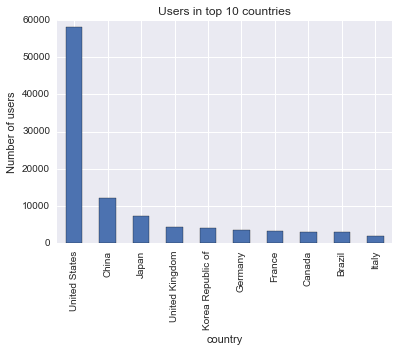

In [56]:
df.groupby('country')['country'].count().sort_values(ascending=False).head(10)
df.groupby('country')['country'].count().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel('Number of users')
plt.title('Users in top 10 countries')
#plt.show()

Histogram of age, fraud/no fraud, purchase value for United states users

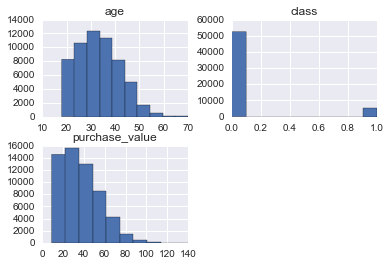

In [57]:
df[df['country'] == 'United States'][['class', 'age', 'purchase_value']].hist()
plt.title('US user distribution')

Number of occurences between Source of costumer aquisition

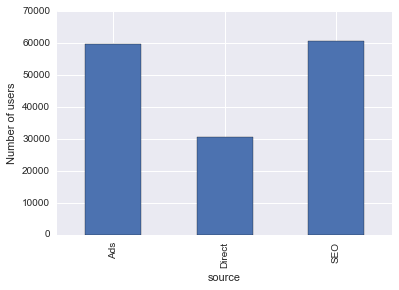

In [58]:
df.groupby('source')['source'].count().plot(kind='bar')
plt.ylabel('Number of users')

Number of Male vs Female users

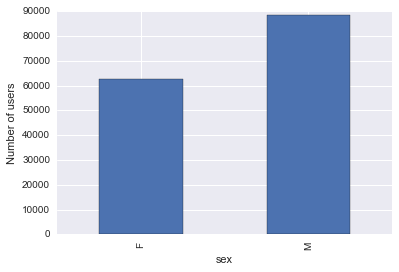

In [59]:
df.groupby('sex')['sex'].count().plot(kind='bar')
plt.ylabel('Number of users')

Class and sex of users

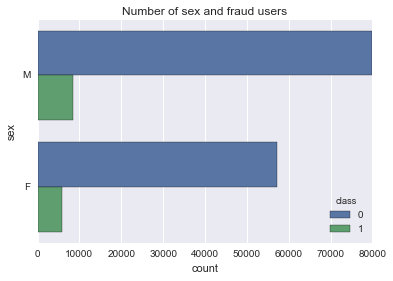

In [60]:
sns.countplot(y="sex", hue='class', data=df)
plt.title('Number of sex and fraud users')

Fraud rate per country (top 25)

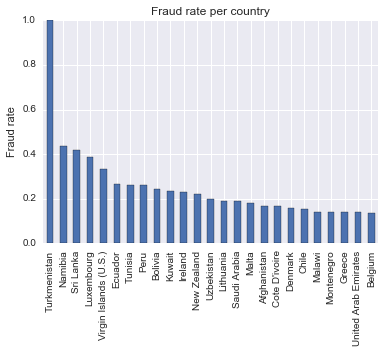

In [61]:
df_fraud_countries = df[df['class'] == 1].groupby('country')['country'].count()
df_allcountries = df.groupby('country')['country'].count()
frauds = pd.concat([df_fraud_countries, df_allcountries], axis=1)
frauds.columns = ['fraud nr','total nr']
frauds = frauds.fillna(0)
frauds['fraud_rate'] = frauds['fraud nr']/frauds['total nr']
frauds.fraud_rate.sort_values(ascending=False).head(25).plot(kind='bar')
plt.ylabel('Fraud rate')
plt.title('Fraud rate per country')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fec2f98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11778f908>]], dtype=object)

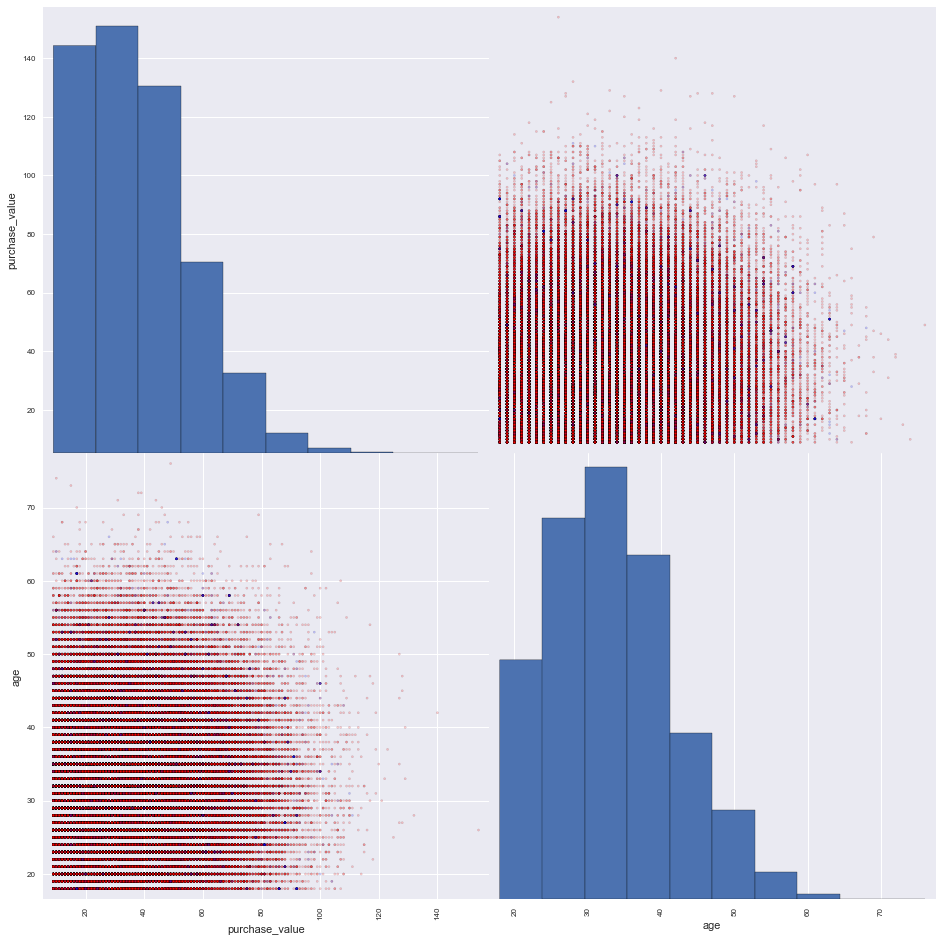

In [62]:
df['conversion_time'] = df.purchase_time - df.signup_time
features = ['purchase_value', 'age']
colors = ['blue' if ix else 'red' for ix in df['class']]
scatter_matrix(df[features], alpha=0.2, figsize=(16, 16), diagonal='hist', c=colors)

The scatter matrix does not show any feature which will clearly separate fraud vs no fraud.

In [86]:
def append_dummies(df,col):
    dummies = pd.get_dummies(df[col],prefix = col)
    df = pd.concat([df,dummies],axis=1)
    df.pop(col)
    return df
def new_features(df):
    df['conversion_time'] = df.purchase_time - df.signup_time
    df['sex'].replace(['F','M'],[1,0],inplace=True)
    df = append_dummies(df, 'source')
    df = append_dummies(df, 'browser')
    df = append_dummies(df,'country')
    return df
df = new_features(df)
#check for devices that have been used for more than 1 user_id
dev = df.groupby('device_id')['user_id'].count()
def check_device_id():
    device = []
    for i in df.device_id:
        if dev[dev.index == i][0] == 1:
            device.append('1_device')
        elif dev[dev.index == i][0] == 2:
            device.append('2_devices')
        else:
            device.append('more_than_2_devices')
        
    return device
df['device'] = check_device_id()
df = append_dummies(df,'device')

Convert timedelta64 into seconds

In [ ]:
df.conversion_time = df.conversion_time.dt.seconds + 60*60*24*df.conversion_time.dt.days

Fraud rate

In [64]:
fraud_rate = df['class'].value_counts() / len(df)
fraud_rate

0    0.906354
1    0.093646
Name: class, dtype: float64

Class is not balanced. In this case I applied oversampling.

In [177]:
def oversample(X, y, target = .45):
    """
    INPUT:
    X, y - data
    target - the percentage of ones class
             observations in the output
    OUTPUT:
    X_new, y_new - oversampled data
    oversample randomly replicates ones observations
    in X, y to achieve the target proportion
    """
    proportion = np.mean(y)
    if proportion > target:
        return X, y
    # determine how many new ones observations to generate
    ones_count = sum(y)
    zeros_count = len(y) - ones_count
    target_ones_count = int(round(target*zeros_count / (1. - target)))
    number_of_new_observations = target_ones_count - ones_count
    # randomly generate new ones observations
    ones_obs_indices = np.where(y==1)[0] # np.where returns a tuple containing an array of indices
    new_obs_indices = np.random.choice(ones_obs_indices, size=number_of_new_observations, replace=True)
    X_new, y_new = X[new_obs_indices], y[new_obs_indices]
    X_ones = np.vstack((X[ones_obs_indices], X_new))
    y_ones = np.concatenate((y[ones_obs_indices], y_new))
    X_zeros = X[y==0]
    y_zeros = y[y==0]
    X_final = np.vstack((X_zeros, X_ones))
    y_final = np.concatenate((y_zeros, y_ones))
    return X_final, y_final

In [88]:
feature = df.columns.tolist()[:]
#remove 'user_id','signup_time','purchase_time', 'device_id', 'ip_address'
del feature[0:3]
del feature[1]
del feature[3]
y = df.pop('class').values
X = df[feature].values
X_final, y_final = oversample(X, y)

In [181]:
fraud_rate = sum(y_final) / len(X_final)
fraud_rate

0.45000000000000001

Class is now balanced and ready to model

Set up data with train/test split

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=67)

First Model : Logistic Regression

In [209]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [210]:
lr.score(X_test,y_test)
import sklearn.metrics as skm
skm.roc_auc_score(y_test, lr.predict(X_test))

0.55093968355955347

As expected the score using a Logistic regression is not very high

In [215]:
gbc = GradientBoostingClassifier(n_estimators=500, max_depth=8, subsample=0.5, 
                                 max_features='auto', learning_rate=0.05)
gbc.fit(X_train, y_train)
gbc.score(X_test,y_test)

0.86264155489518912

The score using a Gradient Boosting Classifier is substantially higher

In [216]:
pd.crosstab(y_test, gbc.predict(X_test))

col_0,0,1
row_0,,
0,26063,1376
1,5465,16900


In [217]:
skm.roc_auc_score(y_test, gbc.predict(X_test))

0.85274869043294677

In [221]:
def plot_confusion_matrix(model, X_test, y_true):
    cm = confusion_matrix(y_true, model.predict(X_test))

    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[26063  1376]
 [ 5465 16900]]


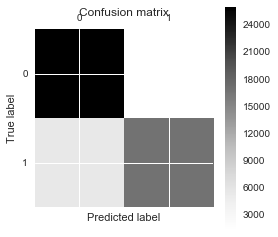

In [222]:
plot_confusion_matrix(gbc, X_test, y_test)

Applying a Random Forest Classifier

In [257]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight='auto')
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)
rfc

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [ ]:
pd.crosstab(y_test, rfc.predict(X_test))

In [225]:
skm.roc_auc_score(y_test, rfc.predict(X_test))

0.99252153713368318

Random Forest Classifier is the model with best performance

[[27047   392]
 [   15 22350]]


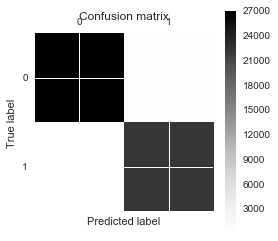

In [226]:
plot_confusion_matrix(rfc, X_test, y_test)

Plot feature importance

In [249]:
def plot_importance(clf, feature, max_features=10):
    '''Plot feature importance'''
    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    # Show only top features
    pos = pos[-max_features:]
    feature_importance = (feature_importance[sorted_idx])[-max_features:]
    feature = np.array(feature)
    feature_names = (feature[sorted_idx])[-max_features:]
    
    plt.barh(pos, feature_importance, align='center')
    plt.yticks(pos, feature_names)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')

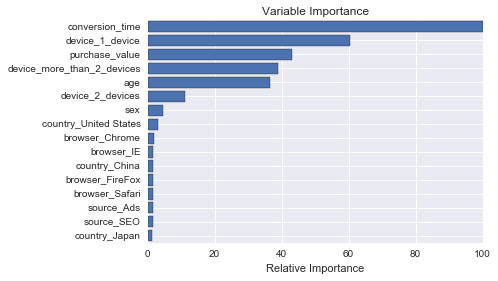

In [251]:
plot_importance(rfc, feature, max_features=16)


Features such as conversion_time, device_1_device, purchase_value, device_more_than_2_devices are the most important in the model

In order to refine model and acheive a better score:
- Scale data
- Perform grid search to find the best tuning parameters for the Random Forestclassifier model
- Compare different classification models


Scale the data

In [255]:
from sklearn.preprocessing import scale
def scale_data(list_of_features):
    for i in list_of_features:
        df.i = scale(df.i)
    return df
df = scale_data(feature)

Grid search

In [207]:
rf_params = {
    'max_depth': [4, 8, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [1, 2, 4],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True], # Mandatory with oob_score=True
    'n_estimators': [50, 100, 200, 400, 500],
    'random_state': [67],
    'oob_score': [True],
    'n_jobs': [-1]
    }
def optimize_hyperparameters(model, params, X_train, y_train):
    gs = GridSearchCV(model(), params, cv=5, n_jobs=-1, verbose=True, scoring='roc_auc')
    gs.fit(X_train, y_train)
    print (gs.best_params_)

    #print best parameters
optimize_hyperparameters(RandomForestClassifier, rf_params, X_train, y_train)
    #rf_grid_cv.best_score_

0